In [141]:
%pylab inline
import pandas as pd
from sklearn import decomposition
import librosa
from  librosa.util import frame
import scipy
import IPython
from IPython.display import display, Audio
from sklearn.cluster import KMeans,DBSCAN, estimate_bandwidth, MeanShift
import os

%run ../utils.py

rc_default()

def savepath(name, thing):
    pathname = '../talk/figs/'+name
    if not os.path.exists(pathname):
        os.makedirs(pathname)
    
    return pathname+'/'+thing
        

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.4/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['indices', 'rec']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [142]:
n_mfcc = 20
sr = 44100
NFFT = 2**12

print(NFFT/sr,'segundos')

HOP = int(NFFT/4)
WIN_LENGTH = NFFT


savefigures = True
saveaudio = True
savevideo = False
savepickle = False

0.09287981859410431 segundos


In [143]:
path = "../wavs/"

sources = [
    
    {'name': 'Partiels',
    'filename':'Grisey_partiels.wav',
     'times':[0,120]
    },
#     {'name': 'Kontakte',
#     'filename':'Stockhausen_Kontakte.wav',
#      'times':[0,None]
#     },
#     {'name': 'Surfin USA',
#     'filename':'BeachBoys_SurfinUSA.wav',
#      'times':[0,None]
#     },
#     {'name': 'Metastasis',
#     'filename':'Xenakis_Metastasis.wav',
#      'times':[0,None]
#     },
#     {'name': 'Music_18_musicians',
#     'filename':'Reich_Music18.wav',
#      'times':[0,None]
#     },
#     {'name': 'Das Madchen',
#     'filename':'Lachenmann_Das_Madchen.wav',
#      'times':[0,None]
#     },
#     {'name': 'Cyclo',
#     'filename':'Cyclo_Ikeda.wav',
#      'times':[0,None]
#     }
    
]

In [144]:
DESCRIPTORS = [

{'name': 'mfcc',
 'params': {'n_mfcc':n_mfcc,'sr':sr},
 'function': lambda self,y: librosa.feature.mfcc(S=Sm, **self.params).T },

{'name': 'rmse',
 'params': {},
 'function': lambda self,y: librosa.feature.rmse(S=Sm).T },

{'name': 'rolloff',
 'params': {'sr':sr},
 'function': lambda self,y: librosa.feature.spectral_rolloff(S=Sm,sr=sr).T },
    
{'name': 'centroid',
 'params': {'sr':sr},
 'function': lambda self,y: librosa.feature.spectral_centroid(S=Sm,**self.params).T },
    
{'name': 'scontrast',
 'params': {'sr':sr} ,
 'function' : lambda self,y: librosa.feature.spectral_contrast(S=Sm, **self.params).T },

{'name': 'chroma',
 'params':{} ,
 'function': lambda self, y: librosa.feature.chroma_stft(S=Sm, **self.params).T }]

In [145]:
df = pd.DataFrame()

for s in sources:
    sr_, track  = wav2audio_segment(path+s['filename'],s['times'][0],s['times'][1])
    
    S = librosa.stft(track,n_fft=NFFT, hop_length=HOP,center=False)
    Sm = abs(S)

    normdata = []
    whitedata = []
    data = []
    multiindex = []

    for D in DESCRIPTORS:
        d = Descriptor(D)
        d.perform(track)
        data.append(d.data)
        normdata.append(normalize(d.data,white=False))        
        whitedata.append( normalize(d.data,white=True)) 

        multiindex += [ (d.name,i) for i in range(d.data.shape[1]) ]

    columns = pd.MultiIndex.from_tuples(multiindex, names=['Descriptor', 'Feature'])
    df = pd.DataFrame(np.hstack(data),columns = columns)
    dfnorm = pd.DataFrame(np.hstack(normdata),columns = columns)
    dfwhite = pd.DataFrame(np.hstack(whitedata),columns = columns)
    
#     if s['name']== 'Surfin USA':
#         df = df.drop('mfcc',1)
#         dfnorm = dfnorm.drop('mfcc',1)
    
    frames = frame(track, frame_length=NFFT, hop_length=HOP)
    frames_time = linspace(0,HOP/float(sr)*frames.shape[1],frames.shape[1])
    normframes = frames/sqrt((frames**2).mean(0))

    s.update({'track':track,'df':df,'dfnorm':dfnorm,'dfwhite':dfwhite,'S':Sm,'frames_time':frames_time,'frames':frames})

/usr/local/lib/python3.4/dist-packages/scipy/io/wavfile.py:267: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [146]:
if savefigures:
    for s in sources:

        plt.figure(figsize=(14,8))

        t = s['frames_time']
        extent = [t[0],t[-1],0,sr/2/1000.]


        plt.imshow(log10(s['S']),aspect='auto',cmap = cm.viridis,interpolation='none', extent=extent,origin='bottom');
        plt.xlabel('Time (seconds)')
        plt.ylabel('Frequency (khz)')

        plt.tight_layout()
        plt.savefig(savepath(s['name'],'spectrum'))
        plt.close()


        df = s['dfnorm']        
        ylab = [df.columns.levels[0][a]+str(df.columns.levels[1][b]) for (a,b) in zip(list(df.columns.labels[0]),list(df.columns.labels[1]))]

        extent = [t[0],t[-1],0,df.values.shape[1]]

        plt.figure(figsize=(14,8))
        plt.imshow(df.values.T,aspect='auto',cmap = cm.viridis,interpolation='none', extent=extent);
        plt.xlabel('Time (seconds)')
        plt.yticks(range(df.values.shape[1],0,-1),ylab,fontsize=12)
        plt.tight_layout()
        plt.savefig(savepath(s['name'],'features'))
        plt.close()
        
        df = s['dfwhite']        
        ylab = [df.columns.levels[0][a]+str(df.columns.levels[1][b]) for (a,b) in zip(list(df.columns.labels[0]),list(df.columns.labels[1]))]

        extent = [t[0],t[-1],0,df.values.shape[1]]

        plt.figure(figsize=(14,8))
        plt.imshow(df.values.T,aspect='auto',cmap = cm.viridis,interpolation='none', extent=extent);
        plt.xlabel('Time (seconds)')
        plt.yticks(range(df.values.shape[1],0,-1),ylab,fontsize=12)
        plt.tight_layout()
        plt.savefig(savepath(s['name'],'features_white'))
        plt.close()

In [147]:
for s in sources:
    X = s['dfnorm']
    pca = decomposition.PCA(n_components=X.shape[1])
    Xpca = pca.fit_transform(X)
    maxpca= where(cumsum(pca.explained_variance_ratio_)>0.9)[0][0]
    Xpca = Xpca[:,:maxpca]
    
    if savefigures:
        plt.figure(figsize=(14,6))
        sep = 15
        plt.plot(s['frames_time'],Xpca+arange(maxpca)*sep,'k');
        plt.xlabel('Time (seconds)')
        plt.yticks(range(0,maxpca*sep,sep),['pca '+str(i+1) for i in range(maxpca)]);
        plt.savefig(savepath(s['name'],'pca'))
        plt.close()

    s.update({'Xpca':Xpca})
    

In [148]:
def plotfunc():
    fig,ax = plt.subplots(figsize=(8,8))
    im = imshow(rec, extent=[0,duration,0,duration],cmap=cm.viridis,vmin=np.nanmin(rec),vmax=np.nanmax(rec),origin='bottom');
    fig.colorbar(im,fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig,ax

for s in sources:
    duration = s['track'].size/sr
    
    
    rec = librosa.segment.recurrence_matrix(s['dfnorm'].values.T,k=1500,metric='euclidean',sym=True,mode='distance')
    rec[rec==0]=np.nan
        
    if savefigures:
        plotfunc()
        plt.savefig(savepath(s['name'],'recurrence'))
        plt.close()

        rec = librosa.segment.recurrence_matrix(s['Xpca'].T,k=1500,metric='euclidean',sym=True,mode='distance')
        rec[rec==0]=np.nan

        plotfunc()
        plt.savefig(savepath(s['name'],'recurrence_pca'))
        plt.close()

    if savevideo:
         audiofigure(plotfunc,duration,path+s['filename'],fps=10,figsize=(8,8),ylim=(0,duration),videoname=savepath(s['name'],'recurrence_video')+'.mp4',HTML_OUT=False)


In [149]:
if saveaudio:
    for s in sources:
        idx = lexsort(np.flipud(s['Xpca'].T))
        framesorder = s['frames'][:,idx]
        outsignal = framesoverlap(framesorder,HOP, WIN_LENGTH )
        librosa.output.write_wav(savepath(s['name'],'pca_sorted')+'.wav',outsignal,sr=sr)
    #     display(Audio(data=outsignal,rate=sr))

In [150]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse.csgraph import reverse_cuthill_mckee

for s in sources:
    X = s['Xpca']
    nbrs = NearestNeighbors(n_neighbors=20, algorithm='brute',metric='euclidean').fit(X) #kd_tree
    distances, indices = nbrs.kneighbors(X)    
    B = nbrs.kneighbors_graph(X)
    
    # B = B - scipy.sparse.diags(ones(B.shape[0]))
    if savefigures:
        plt.figure(figsize=(8,8),dpi=70)
        Y = B.toarray()
        im = imshow(Y,interpolation='none', extent=[0,duration,0,duration],cmap=cm.Greys,vmin=np.nanmin(Y),vmax=np.nanmax(Y),origin='bottom');

        plt.savefig(savepath(s['name'],'kneighbors'))
        plt.close()

        plt.figure(figsize=(8,8),dpi=70)
        perm = reverse_cuthill_mckee( B )
        Y = B.toarray()
        im = imshow(Y[perm,:][:,perm],interpolation='none', extent=[0,duration,0,duration],cmap=cm.Greys,vmin=np.nanmin(Y),vmax=np.nanmax(Y),origin='bottom');
        plt.savefig(savepath(s['name'],'cuthillmckee'))

        plt.close()
    
    if saveaudio:
        outsignal = framesoverlap(s['frames'][:,perm],HOP, WIN_LENGTH )
        librosa.output.write_wav(savepath(s['name'],'cuthillmckee')+'.wav',outsignal,sr=sr)
    #     display(Audio(data=outsignal,rate=sr))

In [151]:

for k,s in enumerate(sources):
    X = s['Xpca']
    n_clusters=X.shape[1]
    labels = KMeans(n_clusters=n_clusters, random_state=170).fit_predict(X)
    s.update({'labels':labels})
#         print(s['name'])
    if saveaudio:
        for i in range(n_clusters):
            outsignal = framesoverlap(s['frames'][:,labels==i],HOP, WIN_LENGTH )
            librosa.output.write_wav(savepath(s['name'],'cluster_')+str(i)+'.wav',outsignal,sr=sr)

        #         display(Audio(data=outsignal,rate=sr))


In [152]:
from scipy.signal import savgol_filter,resample_poly
resampling = 3
for i,s in enumerate(sources):
    Xpca_resample = resample_poly(s['Xpca'],1,resampling)
    s.update({'Xpca_resample':Xpca_resample})
    

In [153]:
from sklearn import manifold
import multiprocessing 

for i,s in enumerate(sources):
    X = s['Xpca_resample']
    mani2 = manifold.MDS(n_components=2,n_jobs = multiprocessing.cpu_count())
    M2 = mani2.fit_transform(X)
    mani3 = manifold.MDS(n_components=3,n_jobs = multiprocessing.cpu_count())
    M3 = mani3.fit_transform(X)
    
    s.update({'MDS2':M2,'MDS3':M3})

In [154]:
for i,s in enumerate(sources):
    M = s['MDS2']
    time_color = plt.cm.jet(np.linspace(0,1,M.shape[0]))
    plt.figure(figsize=(8,8))
    plt.plot(M[:, 0], M[:, 1],'k',alpha=0.2)
    plt.plot(M[0, 0], M[0, 1],'dk',alpha=0.4,ms=20)
    plt.plot(M[-1, 0], M[-1, 1],'*k',alpha=0.4,ms=20)
    cl = colorline(M[:, 0], M[:, 1],cmap=plt.cm.jet,alpha=0.4)
    # plt.scatter(M[:, 0], M[:, 1],c=time_color,alpha=0.4, edgecolors='none',s=30);
    colorbar(cl)
    plt.savefig(savepath(s['name'],'mdstime2'))
    plt.close()

In [155]:
fig = figure(figsize=(14,6))

for i,s in enumerate(sources):
    M = s['MDS3']
    time_color = plt.cm.jet(np.linspace(0,1,M.shape[0]))

    subplot(1,2,1)
    cl = colorline(M[:, 0], M[:, 1],cmap=plt.cm.jet,alpha=0.4)
    gca().autoscale(True)
    xlabel('Dim 1')
    ylabel('Dim 2')
    
    subplot(1,2,2)
    cl = colorline(M[:, 0], M[:, 2],cmap=plt.cm.jet,alpha=0.4)
    gca().autoscale(True)
    xlabel('Dim 1')
    ylabel('Dim 3')
          
    colorbar(cl,label='Normalized time')
        
    
    plt.savefig(savepath(s['name'],'mdstime22'))
    plt.close()

In [156]:
# %matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D

fig = figure(figsize=(14,14))
ax = fig.gca(projection='3d')

for i,s in enumerate(sources):
    M = s['MDS3']
    x = M[:,0]
    y = M[:,1]
    z = M[:,2]
        
    N = len(x)
    for i in range(0,N-1,1):
        ax.plot(x[i:i+2], y[i:i+2], z[i:i+2], color=plt.cm.jet(i/float(N)))
        
        
    plt.savefig(savepath(s['name'],'mdstime3'))
    plt.close()

In [157]:
for i,s in enumerate(sources):

    M = s['MDS2']
    X = s['Xpca_resample']
    n_clusters = X.shape[1]
    labels = KMeans(n_clusters=n_clusters, random_state=170).fit_predict(X)
    s.update({'kmeans_labels_resample':labels})
    n_clusters = np.unique(labels).size
    
    time_color = plt.cm.hsv(labels/float(n_clusters))
    plt.figure(figsize=(8,8))
    plt.plot(M[:, 0], M[:, 1],'k',alpha=0.2)
    for i in range(n_clusters):
        ix = labels==i
        plt.scatter(M[ix, 0], M[ix, 1],c=time_color[ix],alpha=0.4, edgecolors='none',s=30,label='Cluster '+str(i+1));
    
    legend();
    plt.savefig(savepath(s['name'],'mds_kmeans_labels'))
    plt.close()

In [158]:
from sklearn import manifold
import multiprocessing 

for i,s in enumerate(sources):
    X = s['Xpca_resample']
    tsne = manifold.TSNE(n_components=2,random_state=1)
    M = tsne.fit_transform(X)
    s.update({'tsne':M})
    
    plt.figure(figsize=(8,8))
    plt.plot(M[:, 0], M[:, 1],'k',alpha=0.2)
    plt.plot(M[0, 0], M[0, 1],'dk',alpha=0.4,ms=20)
    plt.plot(M[-1, 0], M[-1, 1],'*k',alpha=0.4,ms=20)
    cl = colorline(M[:, 0], M[:, 1],cmap=plt.cm.jet,alpha=0.4)
    # plt.scatter(M[:, 0], M[:, 1],c=time_color,alpha=0.4, edgecolors='none',s=30);
    colorbar(cl)
    plt.savefig(savepath(s['name'],'tsne'))
    plt.close()

In [159]:
for i,s in enumerate(sources):
    X = s['Xpca_resample']
    labels = s['kmeans_labels_resample']
    
    M = s['tsne']

    n_clusters = np.unique(labels).size
    
    time_color = plt.cm.hsv(labels/float(n_clusters))
    plt.figure(figsize=(8,8))
    plt.plot(M[:, 0], M[:, 1],'k',alpha=0.2)
    for i in range(n_clusters):
        ix = labels==i
        plt.scatter(M[ix, 0], M[ix, 1],c=time_color[ix],alpha=0.4, edgecolors='none',s=30,label='Cluster '+str(i+1));
    
    legend();
    plt.savefig(savepath(s['name'],'tsne_kmeans_labels'))
    plt.close()

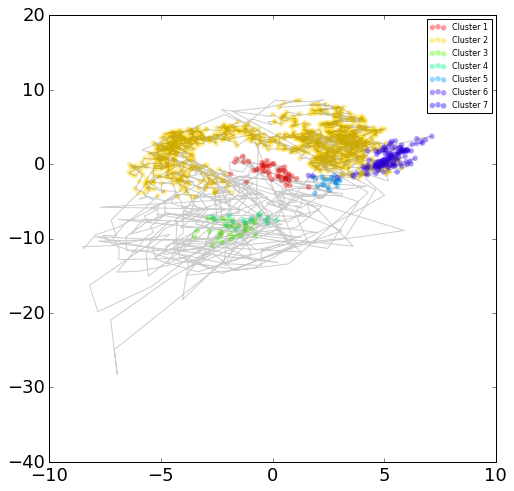

In [173]:
for i,s in enumerate(sources):

    M = s['MDS2']
    X = s['Xpca_resample']
    db = DBSCAN(eps=mean(abs(X))*1.5,min_samples=20,n_jobs = multiprocessing.cpu_count()).fit(X)
    labels = db.labels_
    
    s.update({'dbscan_labels_resample':labels})
    n_clusters = np.unique(labels).size
       
    time_color = plt.cm.hsv(labels/float(n_clusters))
    plt.figure(figsize=(8,8))
    plt.plot(M[:, 0], M[:, 1],'k',alpha=0.2)
    for i in range(n_clusters):
        ix = labels==i
        plt.scatter(M[ix, 0], M[ix, 1],c=time_color[ix],alpha=0.4, edgecolors='none',s=30,label='Cluster '+str(i+1));
    
    legend();
    plt.savefig(savepath(s['name'],'mds_dbscan_labels'))

In [161]:
mean(abs(X))

1.3931058572462665

In [162]:
import pickle

if savepickle:1
    with open('fullprocess.pickle', 'wb') as handle:
      pickle.dump(sources, handle)

IndentationError: unexpected indent (<ipython-input-162-e14460e4f16a>, line 4)